# Load CIFAR-10 data

In [1]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_val, y_val)=cifar10.load_data()

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_val is {}'.format(x_val.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_val is {}'.format(y_val.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_val is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_val is (10000, 1)


In [2]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

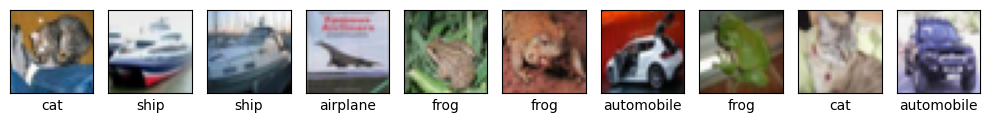

In [3]:
import matplotlib.pyplot as plt

# Plot first 10 test images with labels
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i])
    plt.xlabel(class_names[y_val[i][0]])
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.utils import to_categorical

# Normalizing
x_train=x_train/256.
x_val=x_val/256.

# One hot encoding
y_train_cat=to_categorical(y_train,10)
y_val_cat=to_categorical(y_val,10)

# Data Augmentation

In [5]:
import numpy as np
import cv2
import random

# Gaussian noise
def add_gaussian_noise(img, std=0.06):
    noise = np.random.normal(0, std, img.shape).astype(np.float32)
    noisy_img = img + noise
    return np.clip(noisy_img, 0., 1.)

# Gaussian blur (30% chance)
def random_blur(img, p=0.3):
    if random.random() < p:
        ksize = random.choice([3, 5])  # kernel size
        img_blur = cv2.GaussianBlur(img, (ksize, ksize), 0)
        return img_blur
    return img

# Color jitter on one random channel (brightness only)
def random_color_jitter(img, p=0.5):
    if random.random() < p:
        factor = 0.1 + 0.2 * random.random()  # brightness scale [0.1, 0.3]
        channel = random.randint(0, 2)        # choose R/G/B channel
        img[:, :, channel] = np.clip(img[:, :, channel] * (1.0 + factor), 0., 1.)
    return img

# CutMix
def cutmix(img1, label1, img2, label2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    h, w = img1.shape[:2]
    cx, cy = np.random.randint(w), np.random.randint(h)
    cut_w = int(w * np.sqrt(1 - lam))
    cut_h = int(h * np.sqrt(1 - lam))
    x1 = np.clip(cx - cut_w // 2, 0, w)
    y1 = np.clip(cy - cut_h // 2, 0, h)
    x2 = np.clip(cx + cut_w // 2, 0, w)
    y2 = np.clip(cy + cut_h // 2, 0, h)

    new_img = img1.copy()
    new_img[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))
    new_label = lam * label1 + (1 - lam) * label2
    return new_img, new_label

# Generate augmented dataset
AUGMENT_SIZE = 100000
augmented_images = []
augmented_labels = []

for _ in range(AUGMENT_SIZE):
    i1, i2 = np.random.randint(0, x_train.shape[0], 2)
    img1, label1 = x_train[i1], y_train_cat[i1]
    img2, label2 = x_train[i2], y_train_cat[i2]

    # CutMix
    img, label = cutmix(img1, label1, img2, label2)

    # Blur + Color jitter + Gaussian noise
    img = random_blur(img)
    img = random_color_jitter(img)
    img = add_gaussian_noise(img)

    augmented_images.append(img)
    augmented_labels.append(label)

x_augmented = np.array(augmented_images, dtype=np.float32)
y_augmented = np.array(augmented_labels, dtype=np.float32)

# Concatenate
x_train_aug = np.concatenate((x_train, x_augmented), axis=0)
y_train_aug = np.concatenate((y_train_cat, y_augmented), axis=0)

print(f'Original dataset length: {len(x_train)}')
print(f'Augmented dataset length: {len(x_train_aug)}')

Original dataset length: 50000
Augmented dataset length: 150000


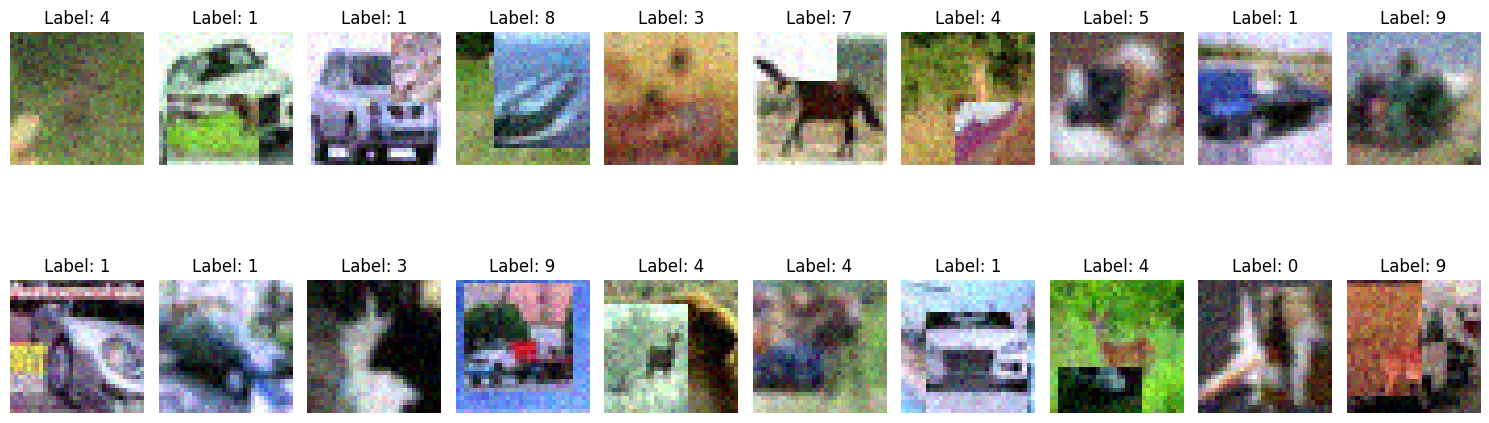

In [6]:
# Display first 20 augmented images
plt.figure(figsize=(15, 6))
for i in range(20):
    img = x_augmented[i]
    label_index = np.argmax(y_augmented[i])
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label_index}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Build Model

In [7]:
LOAD_MODEL = False

In [8]:
# keras import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Activation, Flatten, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model

# User Identified
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.regularizers import l1_l2

#qkeras import
from qkeras import QConv2DBatchnorm, QActivation, QDense, QConv2D
from qkeras.autoqkeras.utils import print_qmodel_summary
from qkeras.utils import load_qmodel

In [ ]:
model=Sequential()
model.add(Input(shape=(32,32,3)))

################### 1st & 2nd conv ###################
model.add(
    QConv2DBatchnorm(
      	filters=16, 
    	kernel_size=(3, 3), 
    	strides=(1, 1), 
    	padding='same',
        kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	bias_quantizer="quantized_bits(8,2,alpha=1)",
        kernel_initializer='he_uniform', 
    	kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), 
    	use_bias=True
    )
)
model.add(QActivation('quantized_relu(8,2)'))

model.add(
    QConv2DBatchnorm(
    	filters=16, 
    	kernel_size=(3, 3), 
    	strides=(1, 1), 
    	padding='same',
        kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	bias_quantizer="quantized_bits(8,2,alpha=1)",
        kernel_initializer='he_uniform', 
    	kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), 
    	use_bias=True
    )
)
model.add(QActivation('quantized_relu(8,2)'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

################### 3rd and 4th conv ###################
model.add(
    QConv2DBatchnorm(
      	filters=20, 
    	kernel_size=(3, 3), 
    	strides=(1, 1), 
    	padding='same',
        kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	bias_quantizer="quantized_bits(8,2,alpha=1)",
        kernel_initializer='he_uniform', 
    	kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), 
    	use_bias=True
    )
)
model.add(QActivation('quantized_relu(8,2)'))

model.add(
    QConv2DBatchnorm(
      	filters=20, 
    	kernel_size=(3, 3), 
    	strides=(1, 1), 
    	padding='same',
        kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	bias_quantizer="quantized_bits(8,2,alpha=1)",
        kernel_initializer='he_uniform', 
		kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), 
    	use_bias=True
    )
)
model.add(QActivation('quantized_relu(8,2)'))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

################### Fully Connected ###################
model.add(
	QDense(
    	20, 
    	kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	kernel_initializer='he_uniform', 
    	kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
    )
)
model.add(BatchNormalization())
model.add(QActivation('quantized_relu(8,2)'))
model.add(Dropout(0.3))

model.add(
  	QDense(
      	10, 
    	kernel_quantizer="quantized_bits(8,2,alpha=1)", 
    	kernel_initializer='he_uniform', 
    	kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
    )
)

In [10]:
model.compile(loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d_batchnorm (QConv2D  (None, 32, 32, 16)       513       
 Batchnorm)                                                      
                                                                 
 q_activation (QActivation)  (None, 32, 32, 16)        0         
                                                                 
 q_conv2d_batchnorm_1 (QConv  (None, 32, 32, 16)       2385      
 2DBatchnorm)                                                    
                                                                 
 q_activation_1 (QActivation  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                      

# Train Model

In [12]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# settings
PATH = 'model.h5'
base_lr, min_lr = 1e-3, 1e-7
total_epochs, warmup_epochs = 150, 5
batch_size = 32

# Learning rate schedule with warm-up and cosine decay
def lr_fn(epoch):
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    else:
        cosine_decay = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        return min_lr + (base_lr - min_lr) * cosine_decay

In [13]:
# Training section
callbacks = [
	LearningRateScheduler(
        lr_fn, 
        verbose=1
    ),
    ModelCheckpoint(
        filepath=PATH, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )
]

In [14]:
history = model.fit(
    				x_train_aug, 
    				y_train_aug,
    				epochs = total_epochs,
    				batch_size = batch_size,
    				validation_data = (x_val, y_val_cat),
    				shuffle = True,
    				callbacks = callbacks
					)


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/150
4687/4688 [============================>.] - ETA: 0s - loss: 2.2577 - accuracy: 0.1962
Epoch 1: val_accuracy improved from -inf to 0.37160, saving model to model.h5
4688/4688 [==============================] - 311s 65ms/step - loss: 2.2577 - accuracy: 0.1962 - val_loss: 1.8704 - val_accuracy: 0.3716 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/150
4687/4688 [============================>.] - ETA: 0s - loss: 2.0665 - accuracy: 0.2786
Epoch 2: val_accuracy improved from 0.37160 to 0.43490, saving model to model.h5
4688/4688 [==============================] - 312s 66ms/step - loss: 2.0665 - accuracy: 0.2786 - val_loss: 1.7184 - val_accuracy: 0.4349 - lr: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/150
4688/4688 [==============================] - ETA: 0s - loss: 1.9885 - accuracy: 0.3335
Epoch 3: val_accuracy did no

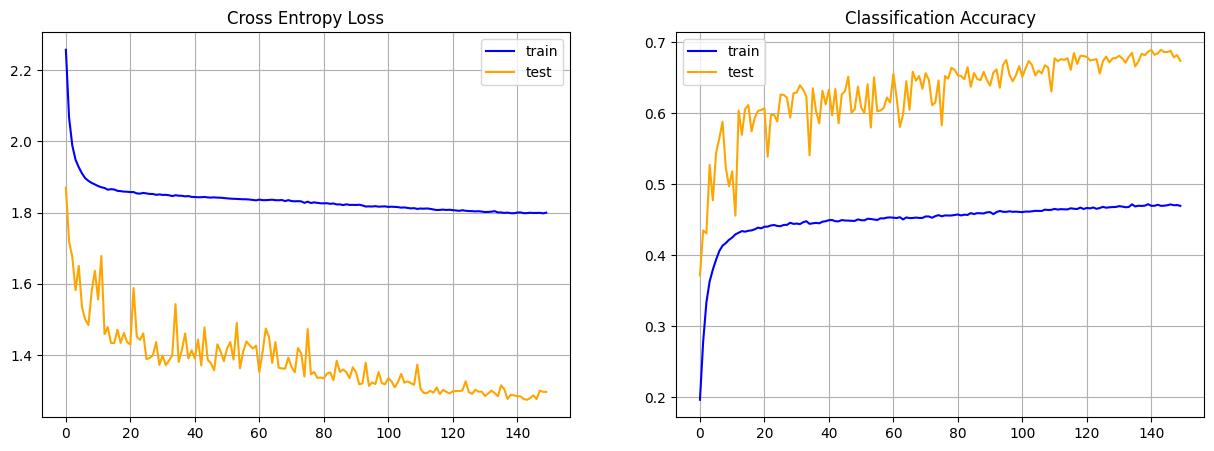

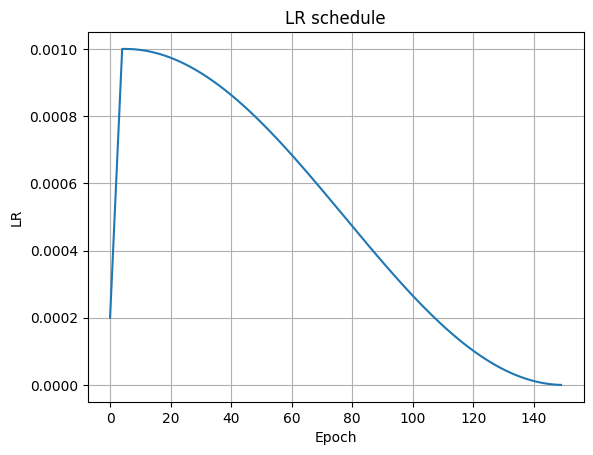

In [15]:
import time

def plot_summary(history):
	plt.figure(figsize=(15, 5))
	# plot loss
	plt.subplot(121)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.legend(loc=0)
	plt.grid(True)

	# plot accuracy
	plt.subplot(122)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(loc=0)
	plt.grid(True)

	plt.show()

def plot_lr(lr_func, epochs):
    plt.plot([lr_func(e) for e in range(epochs)])
    plt.title("LR schedule")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.grid(True)
    plt.show()

plot_summary(history)
plot_lr(lr_fn, total_epochs)

In [16]:
print_qmodel_summary(model)

q_conv2d_batchnorm   f=16 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation         quantized_relu(8,2)
q_conv2d_batchnorm_1 f=16 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_1       quantized_relu(8,2)
q_conv2d_batchnorm_2 f=20 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_2       quantized_relu(8,2)
q_conv2d_batchnorm_3 f=20 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_3       quantized_relu(8,2)
q_dense              u=20 quantized_bits(8,2,0,alpha=1) 
batch_normalization_4 is normal keras bn layer
q_activation_4       quantized_relu(8,2)
q_dense_1            u=10 quantized_bits(8,2,0,alpha=1) 



# Model Prediction Visualization

We use the model to predict labels for the first 10 test images. Each image is displayed along with:
- **GT**: Ground Truth label
- **PR**: Predicted label

In [17]:
import numpy as np

# Predict
y_pred_logits = model.predict(x_val[:10])  # predict on first 10 images
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = y_val[:10]

1/1 [==============================] - 1s 551ms/step


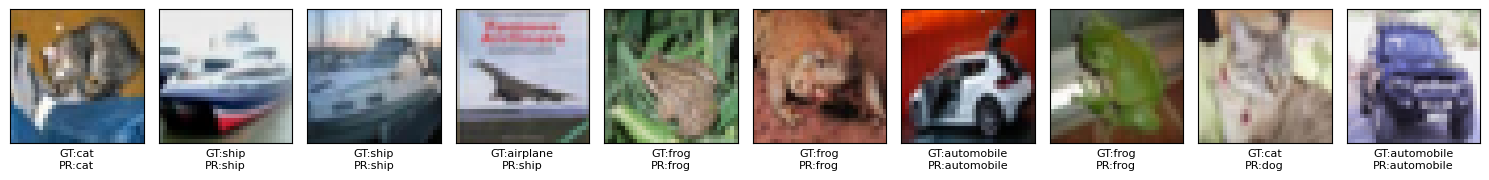

In [18]:
# Plot
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_val[i])
    title = f"GT:{class_names[int(y_true[i])]}\nPR:{class_names[y_pred[i]]}"
    plt.xlabel(title, fontsize=8)
plt.tight_layout()
plt.show()

In [19]:
# Evaluate the Model accuracy on the entire CIFAR-10 Test Set

model.evaluate(x_val, y_val_cat, verbose=1)

313/313 [==============================] - 5s 16ms/step - loss: 1.2966 - accuracy: 0.6738


[1.2965832948684692, 0.673799991607666]